In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)
from syn_model import *
from filter_data import *


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
import plotly.figure_factory as ff
%matplotlib inline
import json


In [60]:

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [61]:
from load_and_clean import *

#update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'MS Zaandam', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Syria', 'Taiwan*', 'West Bank and Gaza', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [62]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)


last date
Exceptions are []


In [63]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

In [7]:
group_a = eu_countries
group_b = ['US']

group_a_label = "EU"
group_b_label = "US"


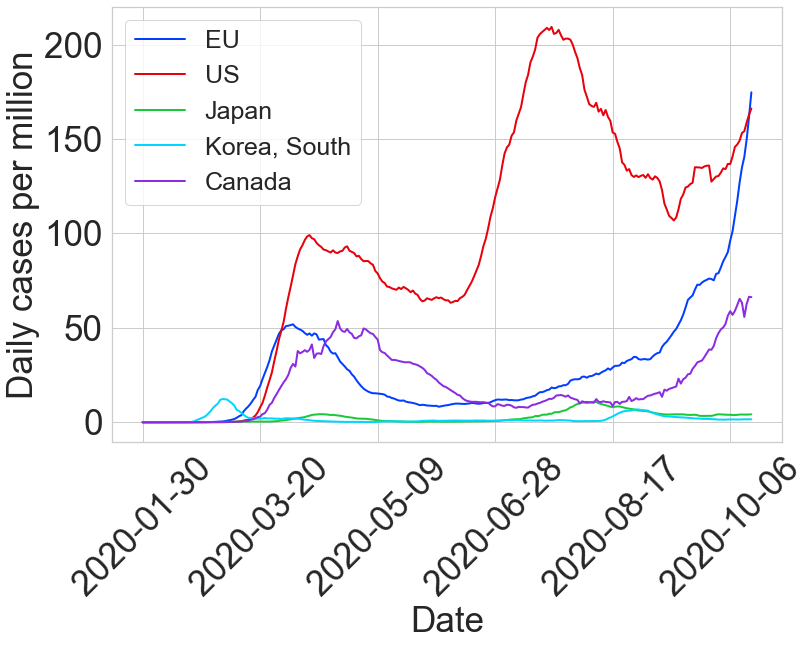

In [8]:
plt.rcParams['figure.figsize'] = (12, 8)
FONTSIZE = 35
dfplot = all_cases_data_pop_daily# all_data_cases_daily

dfplot[group_a].mean(axis=1).plot(label=group_a_label), dfplot[group_b].mean(axis=1).plot(label=group_b_label), 
dfplot['Japan'].plot(), dfplot['Korea, South'].plot(), dfplot['Canada'].plot(), plt.legend(),
plt.xticks(rotation=45,fontsize = FONTSIZE), plt.xlabel('Date', fontsize = FONTSIZE), plt.ylabel('Daily cases per million',fontsize = FONTSIZE)#, plt.title('Cases')
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = 25, loc='upper left')

plt.savefig('../Figures/COVID/Global_cases.pdf', bbox_inches='tight')


In [9]:
groups = [northeast, west, south, midwest]
group_labels = ["North East", "West", "South", "Midwest"]
southwest = south+west

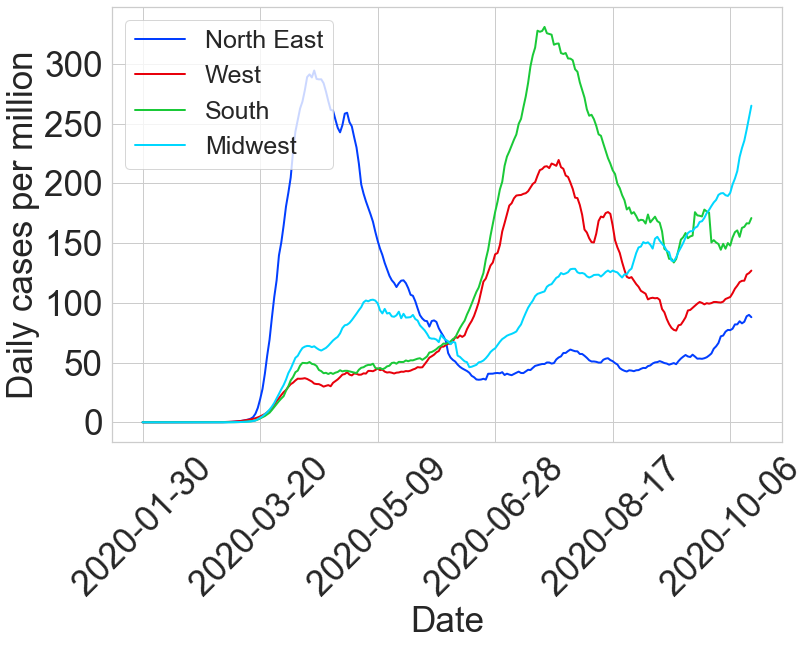

In [10]:
plt.rcParams['figure.figsize'] = (12, 8)
FONTSIZE = 35

dfplot=all_data_cases_daily
i=0
for group in groups:
    (1000000*dfplot[group].sum(axis=1)/(all_population[all_population.index.isin(group)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.ylabel('Daily cases per million', fontsize = FONTSIZE), plt.xlabel('Date' , fontsize = FONTSIZE)#, plt.title('Cases'),
    plt.yticks(fontsize = FONTSIZE)
    plt.legend(fontsize = 25, loc='upper left')
    i=i+1

plt.savefig('../Figures/COVID/US_cases.pdf', bbox_inches='tight')


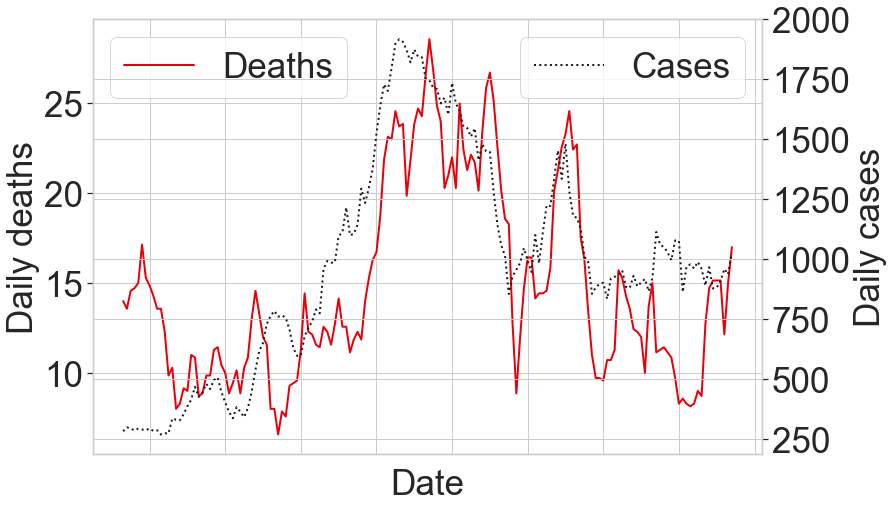

In [11]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Alabama'

#FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

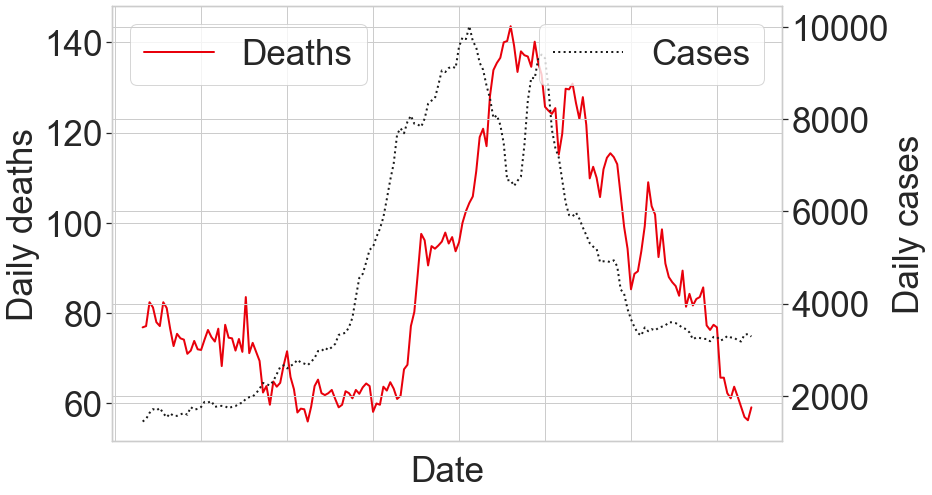

In [12]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='California'

#FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

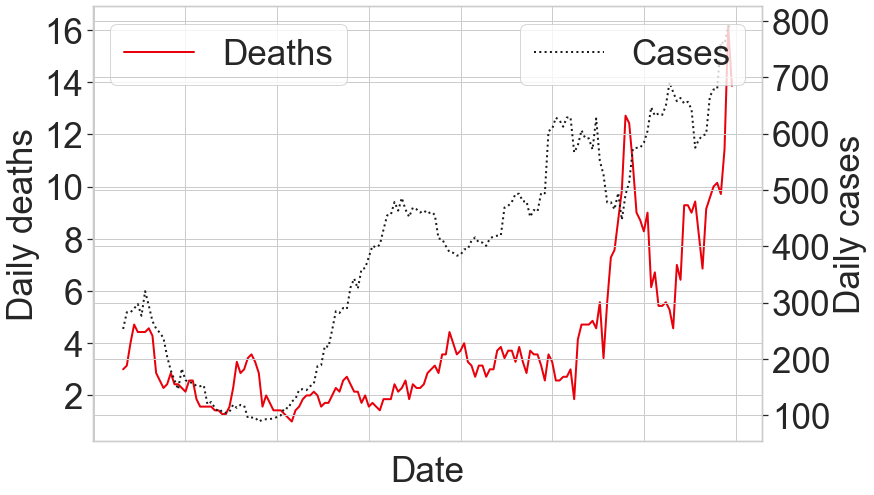

In [13]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Kansas'

#FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

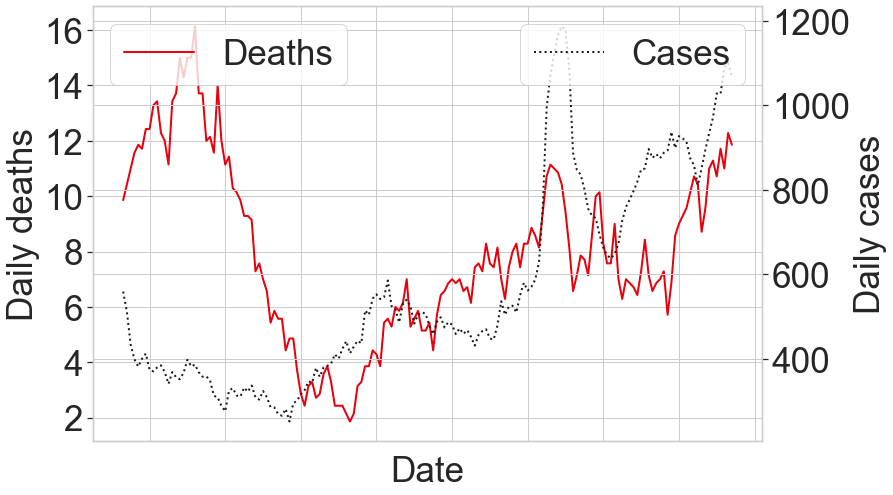

In [14]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Iowa'


deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

In [15]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})

global_deaths_filtered = create_filtered_data(global_deaths, 100 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=35
threshold=50
donorlpool = list(sizes[sizes>threshold].index)
prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)



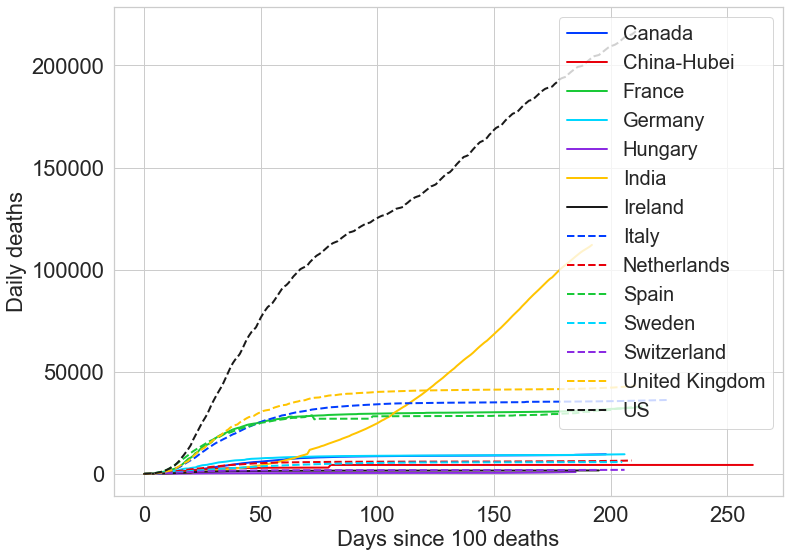

In [16]:
FONTSIZE = 22
fig, ax = plt.subplots()

#group = ['Algeria','Austria', 'Belgium', 'Brazil','Canada-Ontario','Canada-Quebec','China-Hubei','Colombia', 'Czechia', 'Denmark','Ecuador','Egypt','France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom','US']
group = ['Canada','China-Hubei','France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy', 'Netherlands', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom','US']

plt.rcParams['figure.figsize'] = (16.0, 8.0)
#plt.xlim([0,60])
global_deaths_filtered[group].plot(ax = ax,grid=True), plt.xlabel('Days since 100 deaths', fontsize = FONTSIZE), plt.ylabel('Daily deaths', fontsize = FONTSIZE)
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = 20)
#plt.xlim(xmax = 200)
#plt.xticks([0,50,100,150,200])

plt.savefig('../Figures/COVID/aligned_100deaths.pdf', bbox_inches='tight')


FONTSIZE = 35

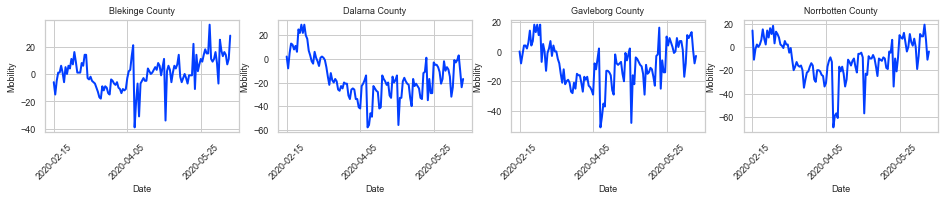

In [17]:
state_list = ['Blekinge County', 'Dalarna County', 'Gavleborg County', 'Norrbotten County']
plt.rcParams['figure.figsize'] = (16,32)

FONTSIZE = 9

#tick_spacing = 30
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "Sweden"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
#fig, ax = plt.subplots(4)
for i in range(4):


    ax = plt.subplot(13,4, i+1)
    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    mobility_us[state_list[i]].plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('Date',fontsize = FONTSIZE), plt.ylabel('Mobility',fontsize = FONTSIZE), plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(state_list[i], fontsize = FONTSIZE)


    
plt.savefig('../Figures/COVID/Swedish Counties.pdf', bbox_inches='tight')

plt.show()


In [40]:
df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
lambdas=[1,0.01]
df1 = cases_intervention_adjusted_daily[df.columns].iloc[15:,:].copy()

#targets = [ 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#targets = newdf.columns
high_thresh = 55
low_thresh = 50
#targets = random.sample(list(deaths_intervention_adjusted_daily.columns),80)
targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index


donorpool = sizes[sizes>=high_thresh].index



singVals = 3
weight_features = []
move_intervention = 10
used_targets = []
for target in targets:
  
    try:
        newdata = synth_control_predictions([df, df1],high_thresh, low_thresh,
                                            "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, silent=True, showDonors=False, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=3000) # error_thresh=1
        if newdata:
            weight_features.append(newdata[0].model_weights())
            used_targets.append(target)
    except ValueError:
        print(target)
        continue
feature_list = pd.DataFrame((weight_features))
feature_list.index = used_targets
feature_list.fillna(0, inplace=True)
#feature_list = feature_list.apply(lambda x: x/x.max(), axis=1)
feature_columns = feature_list.columns
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(feature_list[feature_columns])
feature_list.insert((feature_list.shape[1]),'KMeans',y)
feature_list.groupby('KMeans').groups
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_method='leaf')
clustering_labels = clusterer.fit_predict(feature_list[feature_columns])
feature_list['DB'] = clustering_labels
feature_list.groupby('DB').groups


UnboundLocalError: local variable 'axesLength' referenced before assignment

In [21]:
print(donorpool)
print(df[donorpool])

Index(['Austria', 'Belgium', 'China-Hubei', 'Czechia', 'Denmark', 'Finland',
       'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy',
       'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden',
       'Switzerland', 'United Kingdom', 'Alabama', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Nevada',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'Washington',
       'Wisconsin', 'King-Washington', 'Los Angeles-California',
       'New York City-New York'],
      dtype='object')
      Austria    Belgium  China-Hubei   Czechia   Denmark   Finland  \
8    3.571429  28.

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12, 8)


group = ['New York', 'United Kingdom', 'Italy', 'France']#list(feature_list.groupby('DB').groups[-1])
i = 0
ax = plt.subplot(1,1,1)
tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

df[group].plot(ax = ax, xlim=[0,115])
plt.legend(fontsize=FONTSIZE, loc = 'upper right')
plt.xlabel('Days since lockdown',fontsize=FONTSIZE)#, plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : FONTSIZE}),
plt.ylabel('Daily deaths',fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)
plt.savefig('../Figures/COVID/align.pdf', bbox_inches='tight')
    

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12, 8)
ax = plt.subplot(1,1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.xticks(rotation=45), plt.legend(fontsize=FONTSIZE)
plt.xlabel('Chronolical Date',fontsize=FONTSIZE)#, plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : FONTSIZE}),
plt.ylabel('Daily deaths',fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)
plt.savefig('../Figures/COVID/chron.pdf', bbox_inches='tight')



In [ ]:
FONTSIZE = 22

df = create_peak_clusters(deaths_intervention_adjusted_daily,7)
plt.figure(figsize=(12,8))
#fig, ax = plt.subplots(1,1)
#FONTSIZE = 18

plt.rcParams.update({'font.size': 20})
tick_spacing = 30
# this is a bug in matplotlib
#plt.rcParams['figure.figsize'] = (24.0, 18.0)

#label_markings = ax.get_xticklabels()
#ax.set_xticklabels(label_markings, rotation=45)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention',fontsize=FONTSIZE)#, plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : FONTSIZE}),
plt.ylabel('Peak value',fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)


variablelabel = df.index

for i, txt in enumerate(variablelabel):
    if(df['peak value'][i]>3500):
        plt.annotate(txt, (df['days to peak'][i], df['peak value'][i]+20))

plt.savefig('../Figures/COVID/lockdown_impact.pdf', bbox_inches='tight')

FONTSIZE = 35


In [ ]:
country_population = pd.read_excel("../data/mobility/country_pop_WDI.xlsx")
county_population = pd.read_excel("../data/mobility/co-est2019-annres.xlsx", header=[3])
new = county_population['Unnamed: 0'].str.replace(".","").str.replace(" County","").str.split(pat=",", expand=True)
county_population['state']=new[1].str.strip()
state_population = county_population.groupby('state').sum()
us_state_population = pd.DataFrame()
us_state_population['Country'] = state_population.index
us_state_population['Value'] = state_population[[2019]].values

all_population = pd.concat([country_population, us_state_population], axis=0, ignore_index=True)

In [ ]:

df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()

df1 = cases_intervention_adjusted_daily[df.columns].copy()


In [ ]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)
#plt.rcParams.update({'font.size': 12})
lambdas = [1, 50]

projection_period=120
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))
newdata = synth_control_predictions([df1, df],projection_period, training_period, 
                                            "Cases data", 1, ylimit=[],xlimit =[0,120], savePlots=True, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases')
#error_thresh=10



In [ ]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)

lambdas = [1, 0.02]
projection_period=120
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([df, df1],projection_period, training_period, 
                                            "Deaths data", 1, ylimit=[],xlimit =[0,120], savePlots=True, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=4634, FONTSIZE=30, yaxis = 'Daily deaths')
#error_thresh=10



In [ ]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)
#plt.rcParams.update({'font.size': 12})
lambdas = [1, 50]

projection_period=180
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))
newdata = synth_control_predictions([df1, df],projection_period, training_period, 
                                            "Cases data", 1, ylimit=[], xlimit=(1,200), savePlots=True, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = intervention_date_case)
#xlimit=[110,170]
#error_thresh=10



In [ ]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)

lambdas = [1, 0.02]
projection_period=170
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([df, df1],projection_period, training_period, 
                                            "Deaths data", 1 , savePlots=True, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=4634, FONTSIZE=30, yaxis = 'Daily deaths')
#error_thresh=10
#intervention_date_x_ticks = intervention_date_death
#ylimit=[-5, 30],xlimit =[110,170]



In [ ]:
singVals = 1
projection_period=130
training_period=20

fig, axes = plt.subplots(1, 2, figsize=(26,8))
temp_df,_= filter_data_by_intervention(all_data_daily[['New York']], educational_distancing, 10)

# This has been made silent as to not flood the output
#[pd.concat([deaths_intervention_adjusted_daily,temp_df]
return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], projection_period, training_period, "Deaths data", singVals, ylimit=[], 
                           savePlots=True, do_only=["New York -10"],xlimit =[0,130], showstates=10,
                           exclude=['New York'], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                           svdSpectrum=False, silent=True, showDonors=True, showPlots=True,  mRSC=False, error_thresh = 1700, FONTSIZE=30, yaxis = 'Daily deaths')#lambdas=lambdas, random_distribution=dist



# Mobility Analysis

In [ ]:
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

CTP = load_clean('CTP states')
CTP_pop_adjusted = {name: create_population_adjusted_data(CTP[name], all_population) for name in CTP}

In [ ]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1)  
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1) 
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1)
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1)
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

In [ ]:
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
mobility_data_google['county_state'] = mobility_data_google['sub_region_2'] + '-' + mobility_data_google['sub_region_1']
us_mobility_county = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='county_state')
us_mobility_state =  mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')

In [ ]:
#df_sample = pd.read_csv('minoritymajority.csv') #use if the following line does not work
df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
fips = df_sample[['FIPS', 'STNAME', 'CTYNAME']]

fips.columns = ['fips', 'state', 'county']

In [ ]:
us_mobility_state.index = pd.to_datetime(us_mobility_state.index)
state_adjusted = pd.DataFrame()
for state in us_mobility_state:
    #if state == 'New York' or state == 'New Jersey':
    #    continue
    if (sd_data['name'] == state).any():
        intervention_date = pd.to_datetime(sd_data[sd_data['name'] == state]['last date'].values[0])
        new_col = pd.Series(us_mobility_state[state]
                            [(us_mobility_state[state].index > intervention_date)].values, 
                             name = state)
        

        state_adjusted = pd.concat([state_adjusted, new_col], axis = 1 )

In [ ]:
feature_dict, features = cluster_time_series(state_adjusted.iloc[:30], cluster_method = 'kmeans', n_clusters = 4)                         
colors = get_colors(len(feature_dict), picker = 2)

In [ ]:
plt.rcParams.update({'font.size': 30})
cluster_df = features['cluster'].reset_index()
cluster_df.columns = ['state', 'cluster']

fips.columns = ['fips', 'state', 'county']
cluster_df = pd.merge(cluster_df, fips, how = 'inner', on = 'state')

group = cluster_df['fips']
values = cluster_df['cluster']
fig = ff.create_choropleth(fips=group, values=values, colorscale = colors)
fig.layout.template = None

fig.update_layout(
    font=dict(
        family="Arial",
        size=FONTSIZE
    )
)

fig.show()

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for key in feature_dict:
    group = feature_dict[key]
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = key, c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE), plt.legend(fontsize = FONTSIZE)#plt.title('Cases'),
    plt.xlabel('Date', fontsize = FONTSIZE)
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    i=i+1
    
plt.savefig('../Figures/COVID/mobility_cases.pdf', bbox_inches='tight')

plt.show()


In [ ]:
i = 221
for key in feature_dict:
    ax = plt.subplot(i)
    i += 1
    state_adjusted.iloc[:30][feature_dict[key]].plot(ax = ax, legend=False, figsize = (24, 16))
    #plt.title("Cluster %s" %(key),fontsize = FONTSIZE,position=(0.5, 0.9))

    plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    plt.xlabel("Days since intervention",fontsize = FONTSIZE) 
    plt.ylabel("Average mobility",fontsize = FONTSIZE) 
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.95, "Cluster %s" %(key), transform=ax.transAxes, fontsize=FONTSIZE-5, verticalalignment='top', bbox=props)
    
    
    plt.savefig('../Figures/COVID/mobility_clusters.pdf', bbox_inches='tight')

In [ ]:
#Some descriptive information
for key in feature_dict:
    print('In Group %s'%(key))
    last_day_case = uscases_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Last day population adjusted Cases: Mean %s STD %s"%(last_day_case.mean(), last_day_case.std()))
    
    last_day_death = usdeaths_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Last day Population adjusted Death: Mean %s STD %s"%(last_day_death.mean(), last_day_death.std()))
    
    print("Average Mobility Change %s percent "%(np.mean(state_adjusted.iloc[:30][feature_dict[key]].mean())))
    
    print("\n")
    

# Bars Impact

In [ ]:
ustates_list = list(uscases.columns)
bars_banned = ['Massachusetts', 'New Mexico', 'Kansas', 'District of Columbia', 'Rhode Island', 'North Carolina']
no_bar_no_dining = ['New York', 'New Jersey', 'Connecticut']
indoor_bars = list(set(ustates_list) - set(bars_banned) - set(no_bar_no_dining))
groups = [bars_banned, indoor_bars, no_bar_no_dining]
group_labels = ['Indoor Dining Allowed', 'Indoor Dining and Bars Allowed', 'No dine in, no bars']

In [ ]:
#FONTSIZE = 18
FONTSIZE = 22
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for j,group in enumerate(groups):
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = group_labels[j], c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE), plt.legend(fontsize = 20)#plt.title('Cases'),
    plt.xlabel('Date', fontsize = FONTSIZE)
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    i=i+1
    
plt.savefig('../Figures/COVID/dinein-bars.pdf', bbox_inches='tight')

plt.show()

FONTSIZE = 35


# Prop 99

In [ ]:
directory = os.path.dirname(testdata.__file__)

filename = directory + '/prop99.csv'


df = pd.read_csv(filename)
df = df[df['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
pivot = df.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year'])
dfProp99 = pd.DataFrame(pivot.to_records())

allColumns = dfProp99.columns.values

states = list(np.unique(dfProp99['LocationDesc']))
years = np.delete(allColumns, [0])
caStateKey = 'California'
states.remove(caStateKey)
otherStates = states

yearStart = 1970
yearTrainEnd = 1989
yearTestEnd = 2015

p = 1.0

trainingYears = []
for i in range(yearStart, yearTrainEnd, 1):
    trainingYears.append(str(i))

testYears = []
for i in range(yearTrainEnd, yearTestEnd, 1):
    testYears.append(str(i))

trainDataMasterDict = {}
trainDataDict = {}
testDataDict = {}
for key in otherStates:
    series = dfProp99.loc[dfProp99['LocationDesc'] == key]

    trainDataMasterDict.update({key: series[trainingYears].values[0]})

    # randomly hide training data
    (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(trainDataMasterDict[key]), p)
    trainDataDict.update({key: trainData})
    testDataDict.update({key: series[testYears].values[0]})
series = dfProp99[dfProp99['LocationDesc'] == caStateKey]
trainDataMasterDict.update({caStateKey: series[trainingYears].values[0]})
trainDataDict.update({caStateKey: series[trainingYears].values[0]})
testDataDict.update({caStateKey: series[testYears].values[0]})

trainMasterDF = pd.DataFrame(data=trainDataMasterDict)
trainDF = pd.DataFrame(data=trainDataDict)
testDF = pd.DataFrame(data=testDataDict)

In [ ]:

singvals = 4
rscModel = RobustSyntheticControl(caStateKey, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
rscModel.fit(trainDF)
denoisedDF = rscModel.model.denoisedDF()
predictions = []
predictions = np.dot(testDF[otherStates], rscModel.model.weights)
predictions_noisy = np.dot(testDF[otherStates], rscModel.model.weights)
actual = dfProp99.loc[dfProp99['LocationDesc'] == caStateKey]
actual = actual.drop('LocationDesc', axis=1)
actual = actual.iloc[0]
model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)

fig, ax = plt.subplots(1,1)
tick_spacing = 5
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.rcParams['figure.figsize'] = (12, 8.0)
plt.grid()
plt.plot(years, actual ,label='Actual',color = 'blue')
plt.xlabel('Year', fontsize = FONTSIZE)
plt.ylabel('Per capita cigarette consumption', fontsize = FONTSIZE)
plt.plot(trainingYears, model_fit, linestyle='--', color = 'red') #label='fitted'
plt.plot(testYears, predictions, linestyle='--',color = 'red', label='Synthetic control')
#plt.plot(testYears, predictions_noisy, label='counterfactual noisy')
#plt.title(caStateKey+', Singular Values used: '+str(singvals))
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')

plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
plt.grid()
plt.savefig('../Figures/COVID/prop99_SC.pdf', bbox_inches='tight')




In [ ]:


AB_df = dfProp99.copy()
AB_df = AB_df.drop([4], axis=0)
AB_series = AB_df.mean()
AB_series = AB_series * actual[0]/ AB_series[0]
#print(AB_series[0])
#print(actual[0])



#lt.plot(years,AB_series)


fig, ax = plt.subplots(1,1)
tick_spacing = 5
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.rcParams['figure.figsize'] = (12, 8.0)
plt.grid()


plt.plot(years, actual ,label='Actual',color = 'blue')
plt.xlabel('Year', fontsize = FONTSIZE)
plt.ylabel('Per capita cigarette consumption', fontsize = FONTSIZE)
plt.plot(years, AB_series, linestyle='--', color = 'red',label='rest of the U.S.') #label='fitted'
#plt.plot(testYears, predictions_noisy, label='counterfactual noisy')
#plt.title(caStateKey+', Singular Values used: '+str(singvals))
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')

plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
plt.grid()
plt.savefig('../Figures/COVID/prop99_AB.pdf', bbox_inches='tight')




# Herd Immunity Analysis

## Filter out counties with high RI from donor pool
 

In [64]:
#collect donors pool which consist the counties in cluster_2_state with long spreading time 
#cluster_2_states = no_bar_no_dining = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii

cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

In [65]:
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
tick_spacing=50
FONTSIZE = 28
plt.rcParams['figure.figsize'] = (26, 8.0)


df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

targets = ['Los Angeles-California', 'Broward-Florida','DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']
cluster_2_counties =  []

models = []

for singVals in range(4,5):

    target_model = [] 
    cluster_2_model = []

    #print("Intervention date: ", testDF.index[0])
    for state in targets:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        if state in otherStates:
            otherStates.remove(state)


        rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel.fit_model()
        target_model.append(rscModel)

        predictions = rscModel.predictions
        model_fit = rscModel.model_fit
   
        
        new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
        cluster_2_counties.append(new_state)
        
        if new_state in otherStates:
            otherStates.remove(new_state)

        rscModel2 = syn_model(new_state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel2.fit_model()
        cluster_2_model.append(rscModel2)

        predictions2 = rscModel2.predictions
        model_fit2 = rscModel2.model_fit

    
    models.append((target_model, cluster_2_model)) #Storing both the model for noreasther state and our target state


Analysis for state Los Angeles-California
theory singular value in range 4.2 to 5.9
Analysis for state Niagara-New York
theory singular value in range 4.7 to 6.8


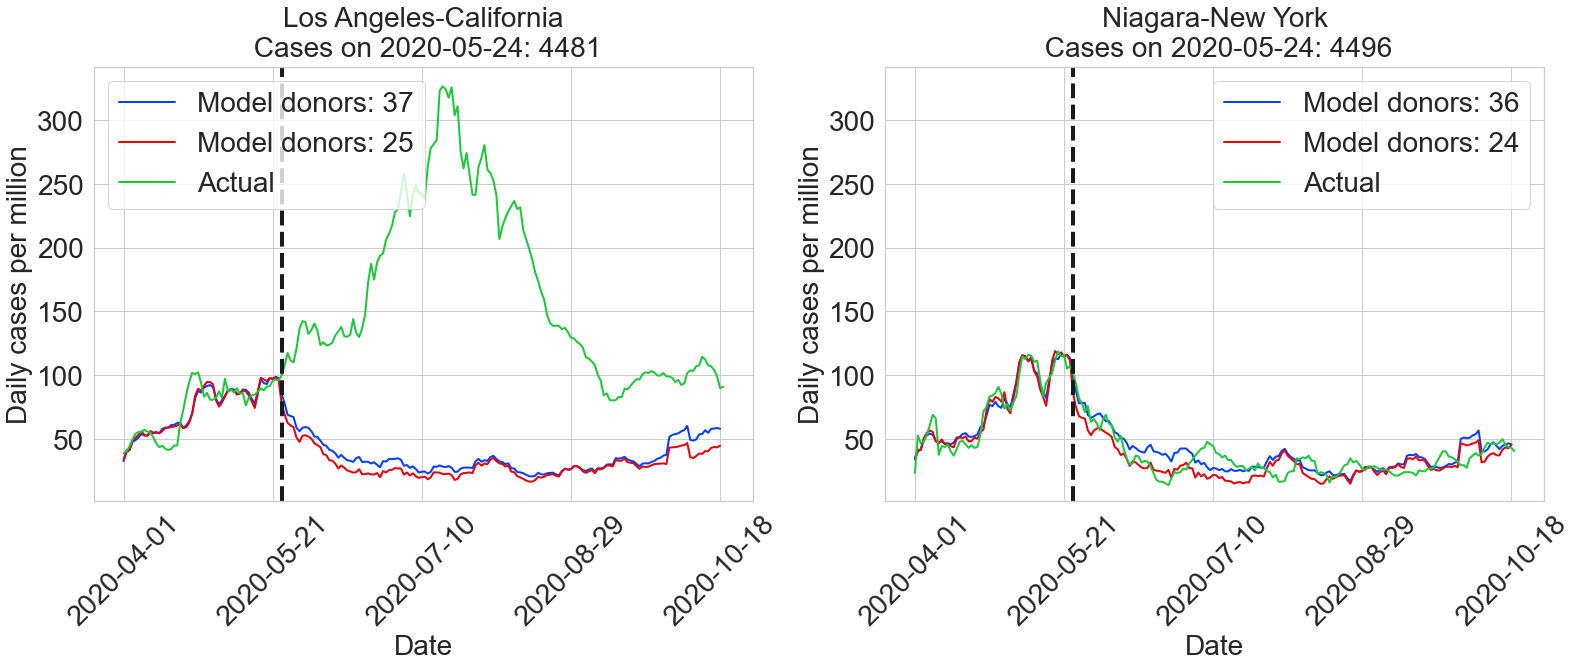

Analysis for state Broward-Florida
theory singular value in range 4.4 to 6.3
Analysis for state Cumberland-Maine
theory singular value in range 4.7 to 6.7


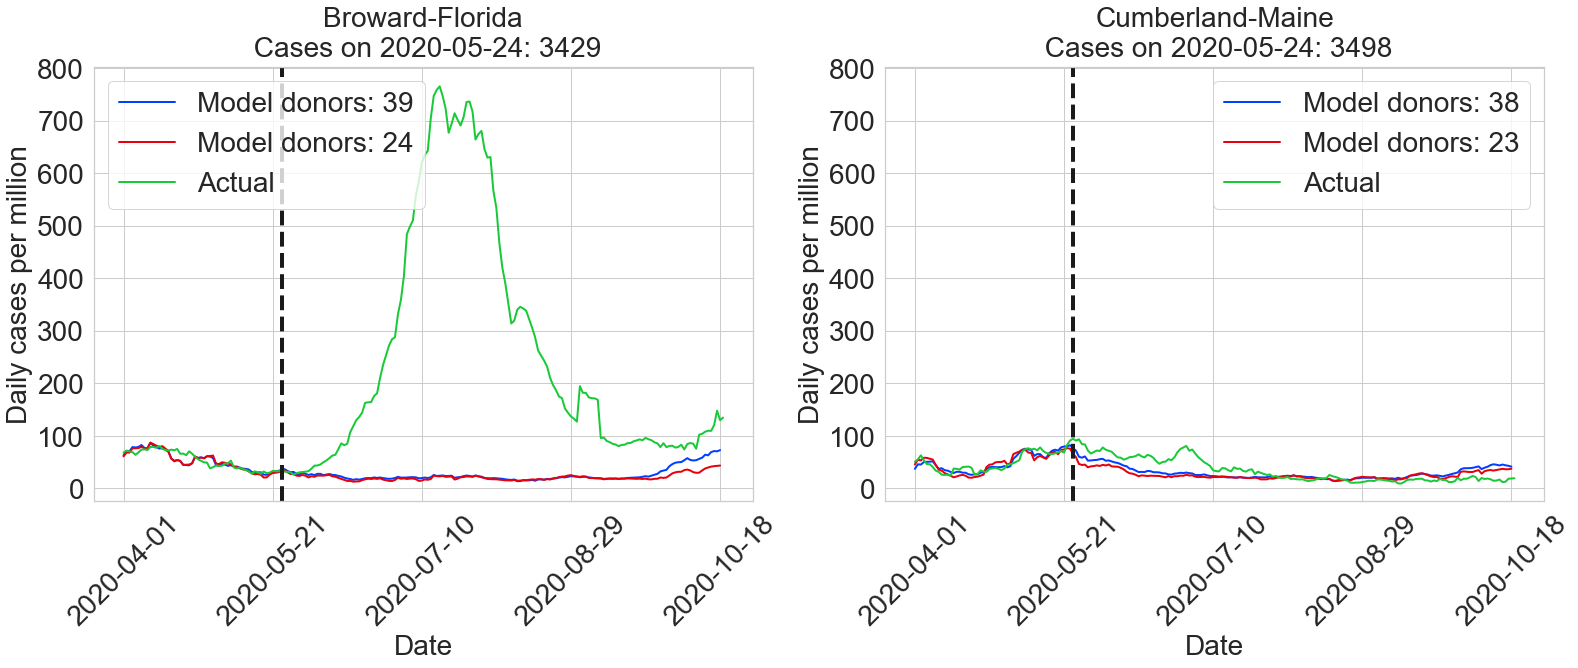

Analysis for state DeKalb-Georgia
theory singular value in range 3.4 to 4.8
Analysis for state Madison-New York
theory singular value in range 4.0 to 5.6


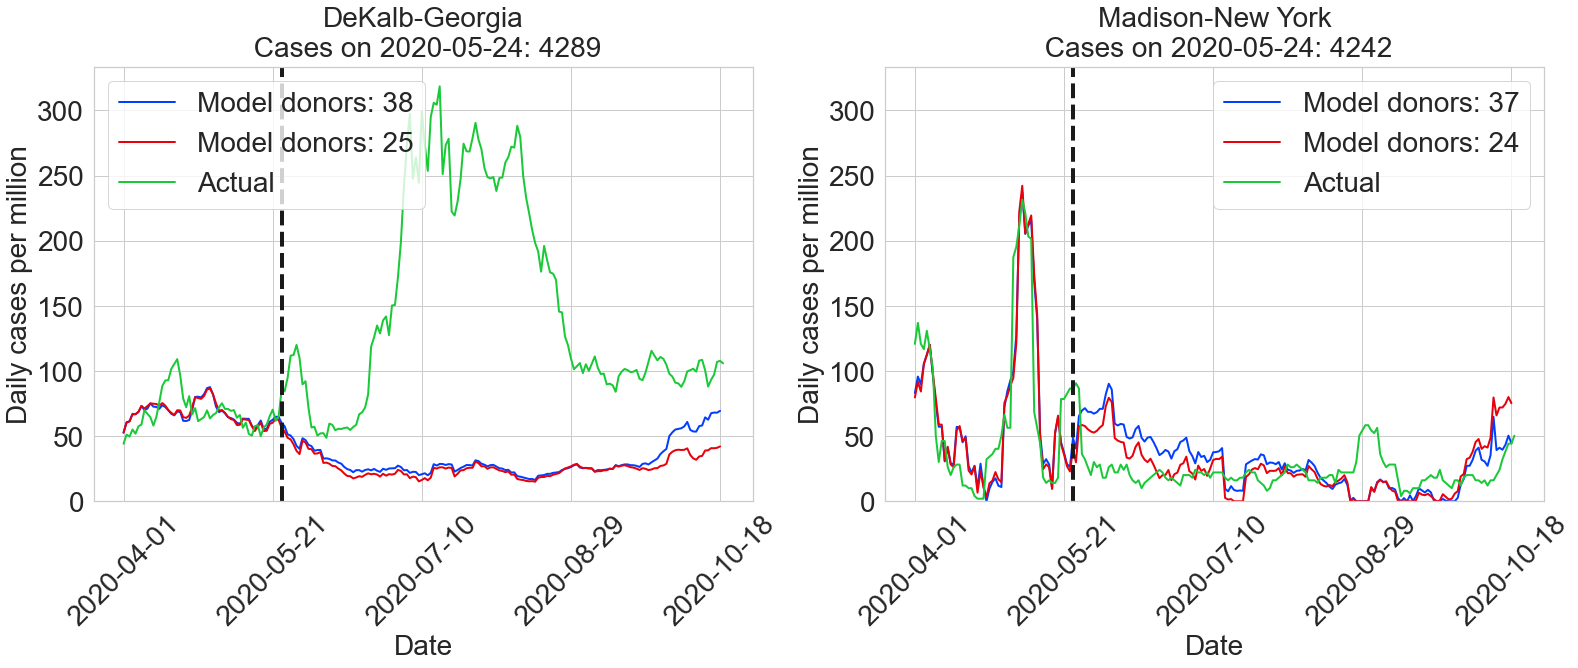

Analysis for state Bartholomew-Indiana
theory singular value in range 3.9 to 5.6
Analysis for state Albany-New York
theory singular value in range 3.4 to 4.9


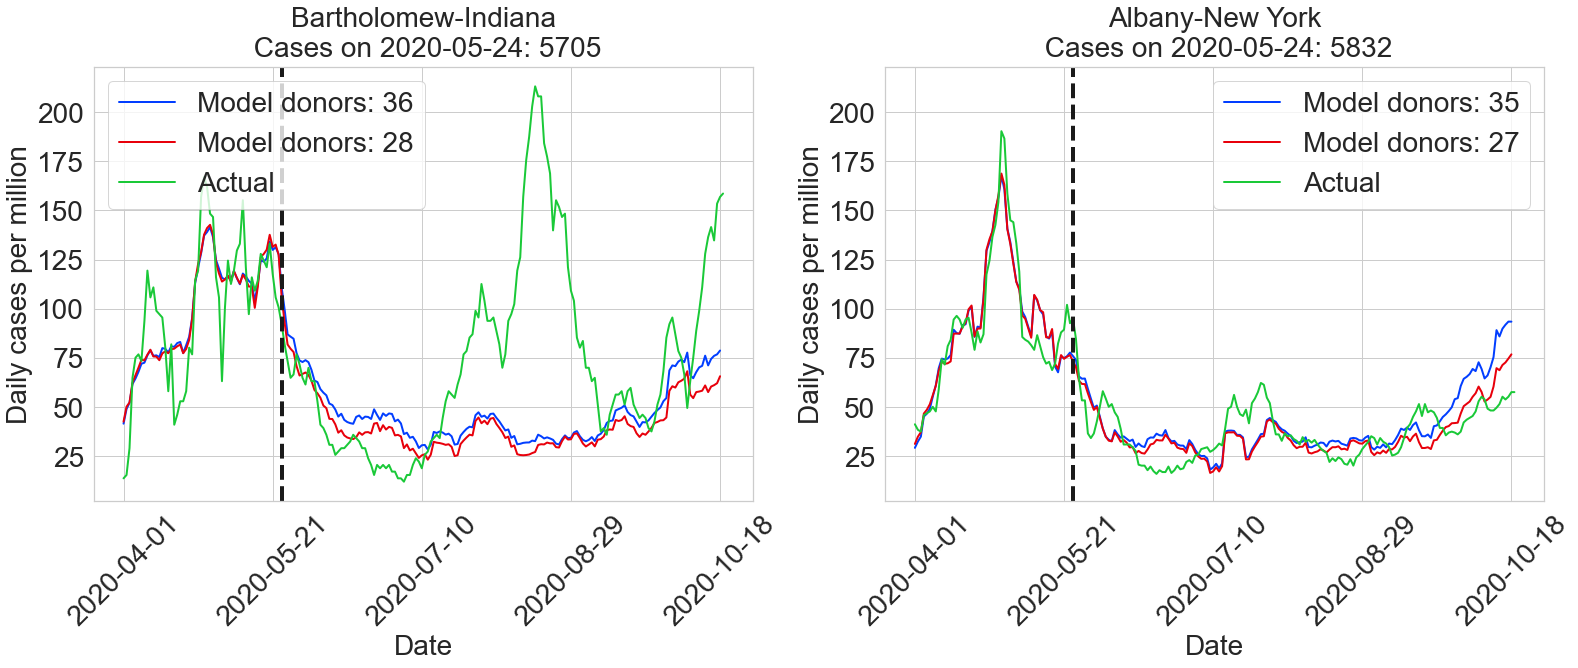

Analysis for state Jefferson-Louisiana
theory singular value in range 4.6 to 6.5
Analysis for state Providence-Rhode Island
theory singular value in range 4.4 to 6.3


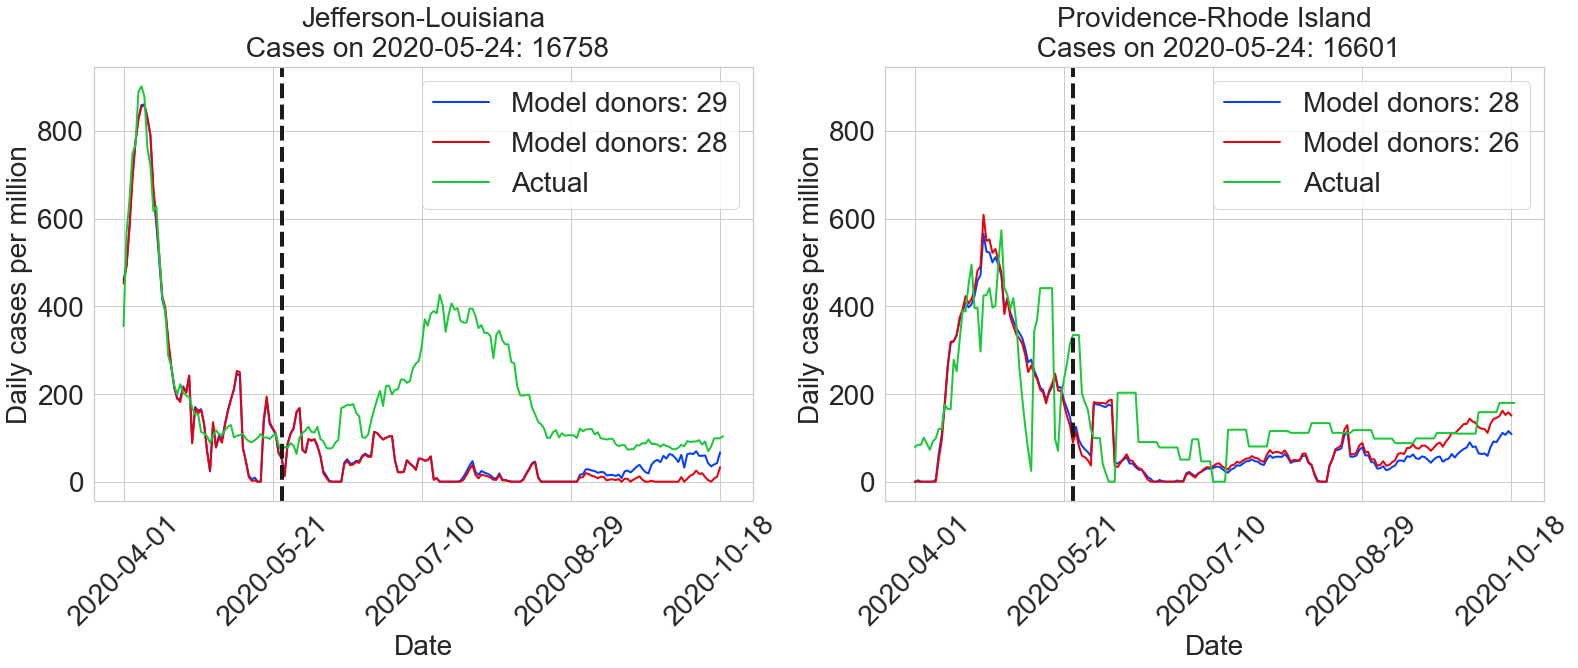

In [68]:
#fig, axes2 = plt.subplots(len(models)+1, 2, figsize = (15, 6*(len(models))+1))
c = 3 #the cut off when generating new donor pool
p = 1.0

old = np.empty((len(models), 2))
new = np.empty((len(models), 2))



new_model_list = []


i = 0# https://www.jmlr.org/papers/volume19/17-777/17-777.pdf

for stat_index in range(len(models[0][0])):
    print("Analysis for state %s"%(models[0][0][stat_index].state))

    X = models[0][0][stat_index].denoisedDF[models[0][0][stat_index].state]
    b = max(X)
    a = min(X)
    X = (X - (a + b)/2)/(b-a)/2
    variance = np.var(X, ddof = 1)
    l = (2.1)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
    h = (3)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
    print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 


    '''
    axes2[i][0].hist(selected, bins = 15)
    axes2[i][0].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(selected), np.std(selected), models[i][0][stat_index].find_ri()))
    '''
    
    (target_model, cluster_2_model) = (models[0][0][stat_index],  models[0][1][stat_index])
    
    #######################
    ########## target_model
    #######################
    state = targets[stat_index]
    
    predictions = target_model.predictions
    model_fit = target_model.model_fit
    
    perm_dict = models[i][0][stat_index].permutation_distribution(show_graph = False)
    #old[i][1] = perm_dict.pop(models[i][0][stat_index].state)
    selected = np.array(list(perm_dict.values()))
    #old[i][0] = np.mean(selected)
    
    #Select new donors
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    selected = selected[selected < c]
    
    new_model = syn_model(models[i][0][stat_index].state,  models[i][0][stat_index].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    new_model_list.append(new_model)
    new_perm_dict = new_model.permutation_distribution(show_graph = False)
    new[i][1] = new_perm_dict.pop(new_model.state)
    values = list(new_perm_dict.values())
    
    new[i][0] = np.mean(values)
    
    new_predictions = new_model.predictions
    new_model_fit = new_model.model_fit
    '''
    axes2[i][1].hist(values, bins = 8)
    axes2[i][1].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(values), np.std(values), new_model.find_ri()))
    '''

    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)
    
    otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                              df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                 > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    if state in otherStates:
            otherStates.remove(state)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model'+" donors: "+str(len(otherStates))), 
    plt.plot(np.concatenate((new_model_fit, new_predictions)), label='Model'+" donors: "+str(len(new_donor))), 
    plt.plot(df[state], label='Actual'), 
    plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    y_min, y_max = ax.get_ylim()
    

    #######################
    ########## cluster_2_model
    #######################
    print("Analysis for state %s"%(models[0][1][stat_index].state))

    X = models[0][1][stat_index].denoisedDF[models[0][1][stat_index].state]
    b = max(X)
    a = min(X)
    X = (X - (a + b)/2)/(b-a)/2
    variance = np.var(X, ddof = 1)
    l = (2.1)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
    h = (3)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
    print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 

    
    
    new_state =  cluster_2_counties[stat_index]

    predictions = cluster_2_model.predictions
    model_fit = cluster_2_model.model_fit

    #Select new donors
    perm_dict = models[i][1][stat_index].permutation_distribution(show_graph = False)
    perm_dict.pop(new_state) 

    #old[i][1] = perm_dict.pop(models[i][1][stat_index].state)
    selected = np.array(list(perm_dict.values()))
    #old[i][1] = np.mean(selected)
    
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    selected = selected[selected < c]

    new_model = syn_model(models[i][1][stat_index].state, models[i][1][stat_index].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    new_model_list.append(new_model)
    new_perm_dict = new_model.permutation_distribution(show_graph = False)
    new[i][1] = new_perm_dict.pop(new_model.state)
    values = list(new_perm_dict.values())
    
    new[i][1] = np.mean(values)
    
    new_predictions = new_model.predictions
    new_model_fit = new_model.model_fit
    

    if new_state in otherStates:
        otherStates.remove(new_state)
    
    ax = plt.subplot(1,2,2)
    #fig, ax = plt.subplots(1,1)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+ "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model'+" donors: "+str(len(otherStates))), 
    plt.plot(np.concatenate((new_model_fit, new_predictions)), label='Model'+" donors: "+str(len(new_donor))), 
    plt.plot(df[new_state], label='Actual'),
    plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    plt.ylim([y_min, y_max])


    
    plt.show()
    ##################  
    
    
    
    

## previous originial graphs 

In [ ]:
pop_scaled = create_population_adjusted_data(uscounties_cases, uscounties_population)
#cluster_2_states = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii
cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

        
targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


In [ ]:

print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")
print("Intervention date: ", testDF.index[0])



In [ ]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=50
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in targets:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    '''
    otherStates = ['Middlesex-Connecticut', 'Essex-Massachusetts', 'Genesee-New York']
    '''
    if state in otherStates:
        otherStates.remove(state)
        
    '''
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit(trainDF)
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    print(model_fit, predictions)
       
        
    '''
    
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0
    
    #print(model_fit)
    #continue
        
    
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:])
    #print(state, fit_error, prediction_error)
    if(len(otherStates)<5):
        print(otherStates)
        continue
    #     if(fit_error > 20):
    #         print(state, fit_error)
    #         continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        print(state)
        continue
        


    #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), 
    plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    y_min, y_max = ax.get_ylim()


    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
    #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
    #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
    #otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if new_state in otherStates:
        otherStates.remove(new_state)
    rscModel = RobustSyntheticControl(new_state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0

    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[new_state][low_thresh+1:])

    #ax = plt.subplot(num_rows_to_plot,2,2*i)
    ax = plt.subplot(1,2,2)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

    plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Prediction'),
    plt.plot(df[new_state], label='Actual'), plt.legend(fontsize = FONTSIZE), 
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE),
    plt.ylim([y_min, y_max])
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
    #plt.savefig("../figures/"+state+".png")

    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    i=i+1

    plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

    plt.show()


In [ ]:
'''
df = pop_scaled.loc['2020-04-01':]


start_date = '2020-04-01'
low_thresh_date = '2020-05-25'
date_check = '2020-05-25'

high_thresh = df.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days - 1
singVals=4

all_diversion = {}
donor_diversion = {}

trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]


for i in range(3000, 21000, 1000):
    
    
    counties_close = find_close(pop_scaled, date_check, i, 500, \
                          county = True)
    
    targets = list(set(counties_close) - set(donors))
    donorpool_counties = list(set(counties_close).intersection(donors))
       
    
    cur_diversion = 0
    d_diversion = 0
    
    target_counts = 0
    donor_counts = 0
    
    
    for state in targets:
    
        #otherStates =  donorpool.copy()
        otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        
        if state in otherStates:
            otherStates.remove(state)
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        
        predictions[predictions < 0 ] = 0
        model_fit[model_fit < 0] = 0
        
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[state][low_thresh+1:])
        diversion = find_testing_diversion(df[state][low_thresh+1:], predictions)
        
        if(fit_error > 20):
            #print(state, 'error is: ', fit_error)
            continue
        if len(otherStates) < 10:
            #print(state, 'donorpools is less than 10 (for targets)')
            continue
        
        cur_diversion += diversion
        target_counts += 1
    all_diversion[i] = abs(cur_diversion/target_counts)
        
    if len(donorpool_counties) == 0:
        #print(i, 'Cluster 2 counties is 0')
        continue
    
    for state in donorpool_counties:
    
        #otherStates =  donorpool.copy()
        otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        
        if state in otherStates:
            otherStates.remove(state)
            
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[state][low_thresh+1:])
        diversion = find_testing_diversion(df[state][low_thresh+1:], predictions)
        
        if len(otherStates) < 10:
            #print(state, 'donorpools is less than 10 (for cluster 2 counties)')
            continue
 
        
        if(fit_error > 20):
            #print(state, 'error is: ', fit_error)
            continue
        donor_counts += 1 
        d_diversion += diversion
    donor_diversion[i] = abs(d_diversion/donor_counts)
'''


In [ ]:
from sklearn.metrics import mean_squared_error

def find_testing_diversion(y_actual, y_pred):
    #return np.sum((y_actual - y_pred) ** 2) / len(y_actual)/np.sqrt(np.square(y_actual).sum())
    
    return np.sum((y_actual - y_pred) ** 2) / len(y_actual) 

#df = pop_scaled.loc['2020-04-01':]
df = all_cases_data_pop_daily.loc['2020-04-01':]

date_check = '2020-05-25'

high_thresh = df.shape[0]
low_thresh = 53
singVals=4

all_diversion = {}
donor_diversion = {}

trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]


for i in range(1000, 20000, 1000):
    
    
    counties_close = find_close(pop_scaled, date_check, i, 500, \
                          county = True)
    
    targets = list(set(counties_close) - set(donors))
    donorpool_counties = list(set(counties_close).intersection(donors))
       
    
    cur_diversion = 0
    d_diversion = 0
    
    target_counts = 0
    donor_counts = 0
    
    for state in targets:
    
        #otherStates =  donorpool.copy()
        otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        
        if state in otherStates:
            otherStates.remove(state)
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(df[state][low_thresh+1:],predictions)
        diversion = find_testing_diversion(df[state][low_thresh+1:], predictions)/pop_scaled.loc['2020-05-25'][state]
            
        if(fit_error > 20):
            #print(state, 'error is: ', fit_error)
            continue
        if len(otherStates) < 10:
            #print(state, 'donorpools is less than 10 (for targets)')
            continue
        if diversion == float("inf"):
            continue
        
        cur_diversion += diversion
        target_counts += 1
    
    all_diversion[i] = ([cur_diversion/target_counts,target_counts] )
    if len(donorpool_counties) == 0:
        #print(i, 'Cluster 2 counties is 0')
        continue    
    for state in donorpool_counties:
    
        #otherStates =  donorpool.copy()
        otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        
        if state in otherStates:
            otherStates.remove(state)
            
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(df[state][low_thresh+1:],predictions)
        diversion = find_testing_diversion(df[state][low_thresh+1:], predictions)/pop_scaled.loc['2020-05-25'][state]
        #diversion = mean_squared_error(predictions,df[state][low_thresh+1:])/pop_scaled.loc['2020-05-25'][state]
        
        if len(otherStates) < 10:
            #print(state, 'donorpools is less than 10 (for cluster 2 counties)')
            continue
 
        
        if(fit_error > 20):
            #print(state, 'error is: ', fit_error)
            continue
        if diversion == float("inf"):
            continue
        donor_counts += 1 
        d_diversion += diversion
    donor_diversion[i] = ([d_diversion/donor_counts, donor_counts])


In [ ]:
FONTSIZE = 22

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (12, 8.0)
#plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
values = list(donor_diversion.values())
plt.scatter(donor_diversion.keys(), [i[0] for i in values], s = [i[1] for i in values], c = 'r', label = 'North Eastern counties MSE')

values = list(all_diversion.values())
plt.scatter(list(all_diversion.keys()), [i[0] for i in values], s = [i[1] for i in values], label = 'Other counties MSE')
ax.yaxis.get_offset_text().set_fontsize(FONTSIZE)
#plt.ylim([0,1300])
#plt.title('Average diversion for counties with close infection rates using states with bars and restuarants closed as donor pool')
plt.ylabel('Average normalized MSE',fontsize = FONTSIZE)
plt.xlabel('Cases per million',fontsize = FONTSIZE)
plt.legend(fontsize = 25)
#plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=FONTSIZE)
plt.savefig('../Figures/COVID/infections_compare.pdf', bbox_inches='tight')
plt.show()


